# Task 1- Feature Selection

## Overview

This notebook addresses feature selection techniques to improve the multi-class classification of network attacks in the **NSL-KDD dataset**. By reducing redundant features (numerical features only), the goal is to enhance model efficiency, minimize computational resources, and improve interpretability.


The dataset, already pre-divided into *training* and *testing* sets, consists of network traffic labeled with four types of network attacks:

- Denial-of-service (DoS), 
- Remote to User (R2L), 
- Probing Attack (Probe), 
- User to Root (U2R).

## Preliminary Setup

### a. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

### b. Data Loading and Initial Inspection

In [2]:
# Load dataset
train_df = pd.read_csv('KDDTrain_CE4317.csv', header=0)
test_df = pd.read_csv('KDDTest_CE4317.csv', header=0)

# Identify numerical columns
col_names = train_df.columns.values
nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 19, 20]
numeric_idx = list(set(range(40)).difference(nominal_idx).difference(binary_idx))
numeric_cols = col_names[numeric_idx].tolist()

# Extract numerical features for training and test sets
train_X = train_df[numeric_cols]
test_X = test_df[numeric_cols]
train_Y = train_df['attack_category']
test_Y = test_df['attack_category']

# Initial data inspection
print(f"Training data shape: {train_X.shape}")
print(f"Testing data shape: {test_X.shape}")
train_X.head()

Training data shape: (25192, 31)
Testing data shape: (22544, 31)


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,491,0,0,0,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,146,0,0,0,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,0,0,0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,232,8153,0,0,0,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,199,420,0,0,0,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### c. Data Visualization - Distribution of Attack Categories

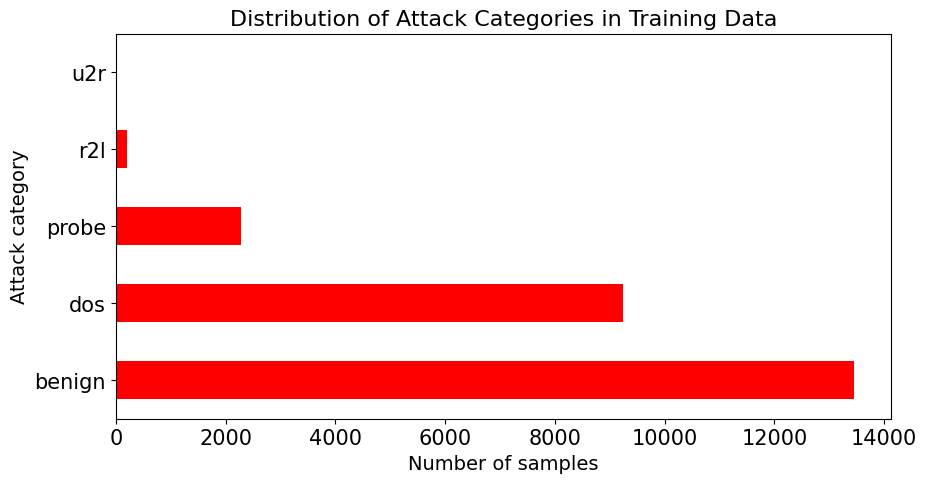

In [3]:
train_attack_cats = train_df['attack_category'].value_counts()
train_attack_cats.plot(kind='barh', figsize=(10,5), fontsize=15, color='red')
plt.xlabel("Number of samples", fontsize=14)
plt.ylabel("Attack category", fontsize=14)
plt.title("Distribution of Attack Categories in Training Data", fontsize=16)
plt.show()


## Part 1: Support Vector Classification

In this section, a *Support Vector Classifier* (**SVC**) is implemented with `kernel='linear'` to classify the network attacks.

### 1.1 Data Scaling

To ensure that all features are on a comparable scale, the data is standardized using `StandardScaler`. Standardizing the features can improve model performance, especially for algorithms like SVC that are sensitive to the scale of input data.

In [4]:
# Data standardization
scaler = StandardScaler().fit(train_X)
train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

### 1.2 Model Training

Then, the linear **SVC** model on the scaled data is trained.

In [5]:
# SVC model training
svc = SVC(kernel='linear')
svc.fit(train_X_scaled, train_Y)

SVC(kernel='linear')

### 1.3 Model Evaluation

The trained model is evaluated on the test data, using **confusion matrix** and **accuracy score** to assess its performance.


Accuracy: 0.7308818310858765


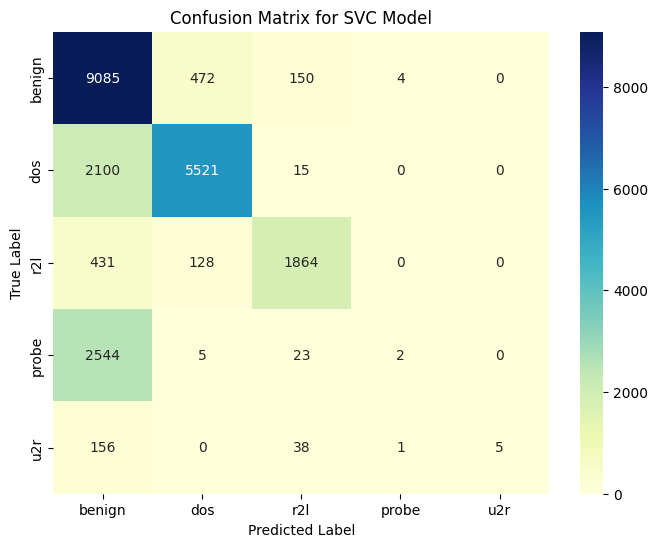

In [6]:
y_pred = svc.predict(test_X_scaled)
conf_matrix = confusion_matrix(test_Y, y_pred)
accuracy = accuracy_score(test_Y, y_pred)

# Accuracy score
print("\nAccuracy:", accuracy)

# Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=train_Y.unique(), yticklabels=train_Y.unique())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SVC Model")
plt.show()

### 1.4 Analysis of the results

The results show that the SVC classifier achieves an accuracy of $73.08\%$ on the test data. The confusion matrix provides further insights, revealing which categories are most commonly misclassified. 

Misclassifications in certain categories may indicate overlapping feature characteristics, suggesting further feature engineering could improve classification accuracy.

## Part 2: Feature Variance

A **Variance Threshold** method is applied to reduce feature dimensionality by discarding low-variance features, which can help improve computational efficiency.

### 2.1 Data Scaling

There's the application of `MinMaxScaler` to standardize features between 0 and 1 for variance thresholding.

In [7]:
# MinMax Scaling
minmax_scaler = MinMaxScaler().fit(train_X)
train_X_minmax = minmax_scaler.transform(train_X)

### 2.2 Variance Calculation

Here is shown the calculation and plotting of variance of features.

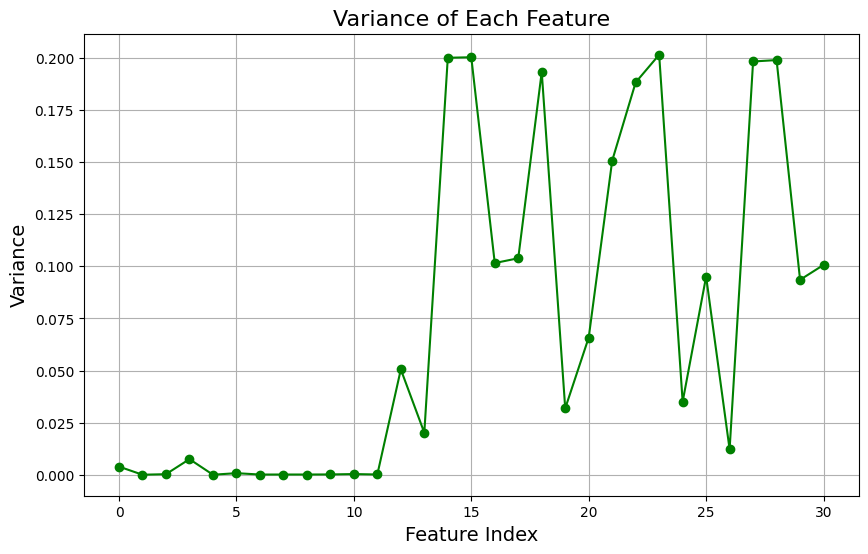

In [8]:
# Variance calculation
variances = np.var(train_X_minmax, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(variances, marker='o', color='green')
plt.xlabel("Feature Index", fontsize=14)
plt.ylabel("Variance", fontsize=14)
plt.title("Variance of Each Feature", fontsize=16)
plt.grid(True)
plt.show()

### 2.3 Threshold Selection

Then, a variance threshold is chosen to discard low-variance features, keeping only the features that meet the variance threshold.

In [9]:
# Feature selection using variance threshold
threshold = 0.01  # Adjust based on the variance plot
selector = VarianceThreshold(threshold=threshold)
train_X_var_selected = selector.fit_transform(train_X_scaled)
test_X_var_selected = selector.transform(test_X_scaled)

### 2.4 Model Training and Evaluation

Finally, there's the training and evaluation of the **SVC** model with the reduced features.

In [10]:
# SVC model with selected features
svc_var_selected = SVC(kernel='linear')
svc_var_selected.fit(train_X_var_selected, train_Y)
y_pred_var_selected = svc_var_selected.predict(test_X_var_selected)
accuracy_var_selected = accuracy_score(test_Y, y_pred_var_selected)

print("\nAccuracy with variance-selected features:", accuracy_var_selected)


Accuracy with variance-selected features: 0.7308818310858765


### 2.5 Comparison

When comparing the original and variance-selected models, the accuracy scores are the same ($73.08\%$). This indicates that the discarded features do not provide additional discriminative power for classification, and that they were redundant or non-informative (so called *noise*). 

The model's decision boundaries remain unchanged, showing that the selected features capture enough variation to maintain performance while reducing dimensionality.

## Part 3: Univariate Feature Selection - `f_classif`

The **ANOVA F-Test** feature selection method (`SelectKBest`) is applied to identify the most statistically significant features.

### 3.1 Feature Count Selection & Model Training

The feature selection for values of $k$ is performed, and then, a new SVC model for each selected subset is trained, recording each accuracy.

In [15]:
# Evaluate accuracy across feature counts
accuracies = []
num_features = train_X.shape[1]
best_accuracy = 0
best_k = 0
best_selected_feature_indices = []

# Variables to track the point of diminishing returns
accuracy_differences = []

# Loop over different values of k
for k in range(1, num_features + 1):
    selector = SelectKBest(score_func=f_classif, k=k)
    train_X_kbest = selector.fit_transform(train_X_scaled, train_Y)
    test_X_kbest = selector.transform(test_X_scaled)
    
    # Train and evaluate SVM
    svc_model_kbest = SVC(kernel='linear')
    svc_model_kbest.fit(train_X_kbest, train_Y)
    predictions_kbest = svc_model_kbest.predict(test_X_kbest)
    accuracy_kbest = accuracy_score(test_Y, predictions_kbest)
    accuracies.append(accuracy_kbest)

    # Update the best accuracy, k, and selected feature indices if current accuracy is higher
    if accuracy_kbest > best_accuracy:
        best_accuracy = accuracy_kbest
        best_k = k
        best_selected_feature_indices = selector.get_support(indices=True)

    # Track the change in accuracy to detect diminishing returns
    if k > 1:
        accuracy_differences.append(accuracies[k - 1] - accuracies[k - 2])

# Find the point where accuracy starts to stabilize (diminishing returns)
threshold = 0.001 
for i in range(1, len(accuracy_differences)):
    if accuracy_differences[i] < threshold:  
        optimal_k = i + 1 
        break

print(f'Optimal number of features: {best_k}')
print(f'Best accuracy: {best_accuracy:.4f}')
print(f"Indices of selected features for best accuracy: {best_selected_feature_indices}") 

Optimal number of features: 31
Best accuracy: 0.7309
Indices of selected features for best accuracy: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


### 3.2 Results Plot 

The **accuracy scores** against the **number of features** are plotted to determine the optimal feature count.

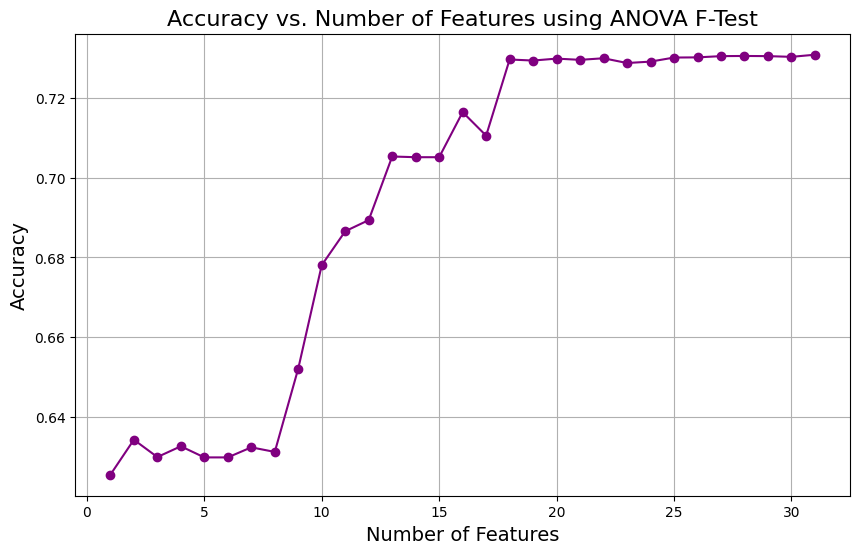

In [17]:
# Plotting accuracy vs number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_features + 1), accuracies, marker='o', color='purple')
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs. Number of Features using ANOVA F-Test", fontsize=16)
plt.grid(True)
plt.show()

### 3.3 Conclusion

The ANOVA F-Test feature selection method (`SelectKBest` with `f_classif`) was employed to identify the most statistically significant features for classifying network attacks. The accuracy vs. number of features plot reveals that:

- **Optimal Number of Features**: The highest accuracy was achieved with $31$ features. This indicates that these features contribute the most to the classification task.
- **Performance Comparison**: The best accuracy obtained through `SelectKBest` is $73.09\%$, which is slightly higher (but not that much) than the original model's accuracy of $73.08\%$. This suggests that a reduced subset of features can maintain or even improve model performance while simplifying the model.

Based on these observations, $31$ features are recommended for the final model, balancing accuracy and feature simplicity.


## Final Conclusions

This notebook explored various feature selection techniques on the NSL-KDD dataset to enhance the classification of network attacks. The following methods were evaluated:

- **Support Vector Classification (SVC)**: Established a baseline model with an accuracy of $73.08\%$.
- **Variance Threshold**: Removed low-variance features, resulting in no change in accuracy ($73.08\%$), indicating that these features were redundant or non-informative.
- **Univariate Feature Selection (`f_classif`)**: Identified the most statistically significant features, achieving an optimal accuracy of $73.09\%$ with $31$ features.

The obtained results highlighted that **Variance Thresholding** effectively reduced feature dimensionality without affecting model performance, and the **ANOVA F-Test** identified a subset of features that slightly improved accuracy, demonstrating the effectiveness of univariate statistical tests in feature selection.


---

# Task 2: Dimensionality Reduction via PCA

This notebook demonstrates the application of *Principal Component Analysis* (**PCA**) for dimensionality reduction, followed by classification using a *Support Vector Machine* (**SVM**).

The goal is to reduce the number of features in the dataset while retaining a specified amount of variance, then train an SVM classifier on the reduced dataset. The performance is compared with a baseline model trained on the original dataset.

## 1. Import Dependencies

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

## 2. Loading the Dataset

This step includes loading the datasets and selecting only the numerical columns for PCA and SVM processing. The response variable is also identified for classification purposes.

In [3]:
# Load dataset
train_df = pd.read_csv('KDDTrain_CE4317.csv', header=0)
test_df = pd.read_csv('KDDTest_CE4317.csv', header=0)

# Identify numerical columns
col_names = train_df.columns.values
nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 19, 20]
numeric_idx = list(set(range(40)).difference(nominal_idx).difference(binary_idx))
numeric_cols = col_names[numeric_idx].tolist()

# Extract numerical features for training and test sets
train_X = train_df[numeric_cols]
test_X = test_df[numeric_cols]
train_Y = train_df['attack_category']
test_Y = test_df['attack_category']

# Initial data inspection
print(f"Training data shape: {train_X.shape}")
print(f"Testing data shape: {test_X.shape}")
train_X.head()

Training data shape: (25192, 31)
Testing data shape: (22544, 31)


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,491,0,0,0,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,146,0,0,0,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,0,0,0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,232,8153,0,0,0,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,199,420,0,0,0,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## 3. Data Preprocessing

Data standardization is performed to ensure that all features are on the same scale. This step is important for PCA, as it is sensitive to the variance of each feature. The dataset is standardized using the `StandardScaler`.

In [4]:
# Standardize the training and test datasets
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

## 4. Defining the PCA and SVM Training Function

A function is defined to perform PCA on the standardized data, retain a specified amount of variance, and then train an SVM classifier. The function evaluates the model’s performance on both the training and test datasets by calculating accuracy and generating a confusion matrix.

In [8]:
# Function to apply PCA and train an SVM
def apply_pca_and_train_svm(variance, train_X_scaled, test_X_scaled, train_Y, test_Y):
    # Initialize PCA with desired variance level
    pca = PCA(n_components=variance)
    train_X_pca = pca.fit_transform(train_X_scaled)
    test_X_pca = pca.transform(test_X_scaled)
    
    # Train an SVM classifier on the transformed data
    svm = SVC(kernel='linear')
    svm.fit(train_X_pca, train_Y)
    test_Y_pred = svm.predict(test_X_pca)
    
    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(test_Y, test_Y_pred)
    conf_matrix = confusion_matrix(test_Y, test_Y_pred)
    
    # Capture the number of components used
    n_components = train_X_pca.shape[1]
    
    return accuracy, conf_matrix, n_components

### Helper function for the Confusion Matrix

In [9]:
def plot_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="PuBuGn", xticklabels=np.unique(test_Y), yticklabels=np.unique(test_Y))
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## 5. Applying PCA with Different Levels of Variance Retention

PCA is applied with different levels of variance retention ($95\%$, $99\%$, $99.9\%$, and $90\%$) to assess the effect of dimensionality reduction on classification performance. The model is trained and evaluated for each variance threshold.

Accuracy with 95.0% variance: 0.7279, Number of Components: 19


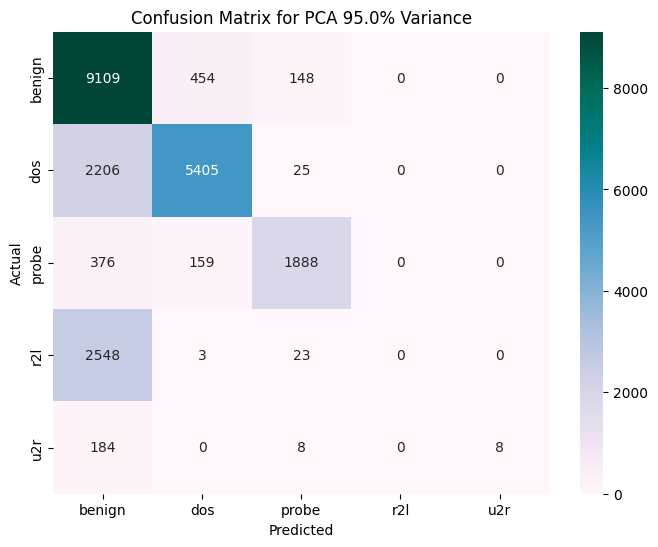

Accuracy with 99.0% variance: 0.7302, Number of Components: 23


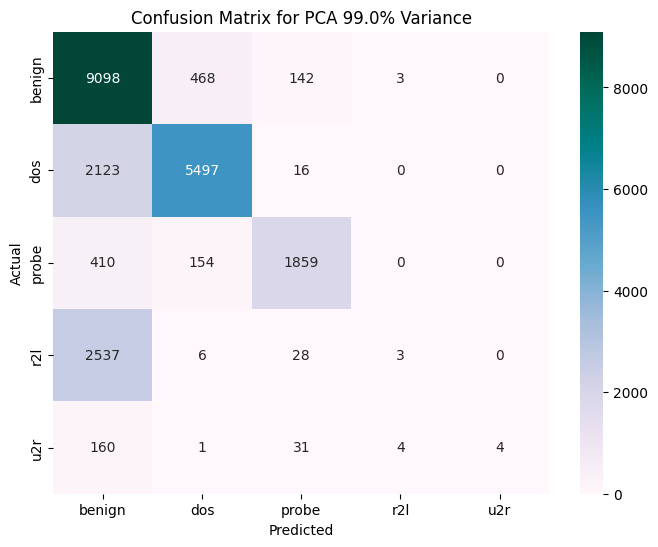

Accuracy with 99.9% variance: 0.7298, Number of Components: 28


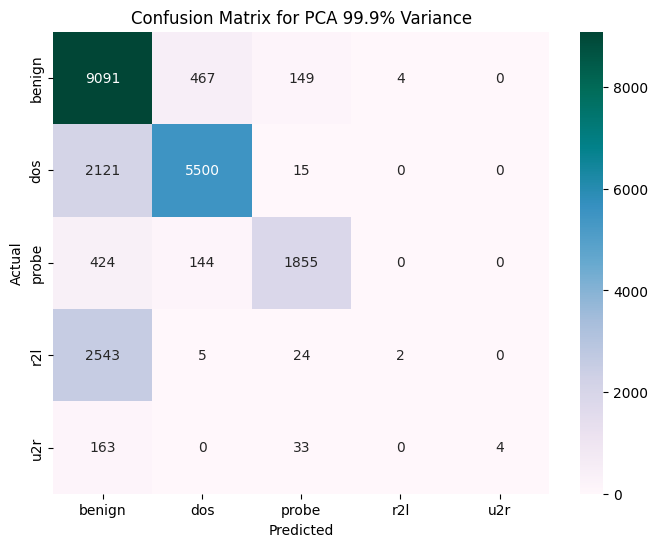

Accuracy with 90.0% variance: 0.7263, Number of Components: 16


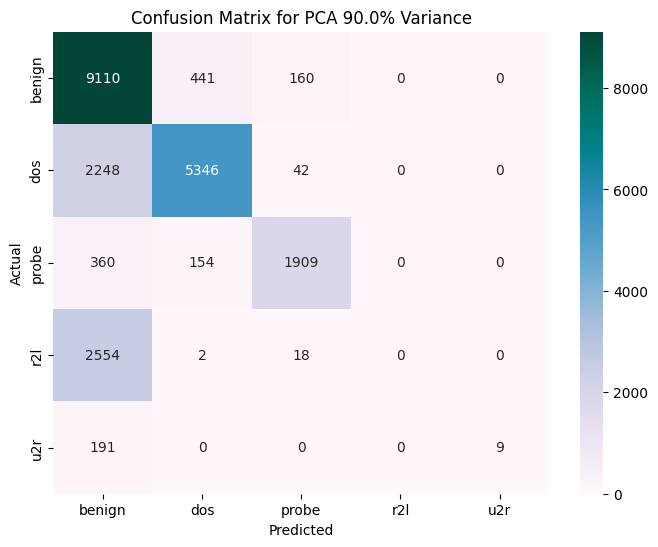

In [10]:
# Define variance levels for PCA
variance_levels = [0.95, 0.99, 0.999, 0.90]

# Apply PCA and evaluate SVM at different variance levels
for variance in variance_levels:
    accuracy, conf_matrix, n_components = apply_pca_and_train_svm(variance, train_X_scaled, test_X_scaled, train_Y, test_Y)
    print(f"Accuracy with {variance*100}% variance: {accuracy:.4f}, Number of Components: {n_components}")
    plot_confusion_matrix(conf_matrix, f"Confusion Matrix for PCA {variance*100}% Variance")

## 6. Training a Baseline SVM Model

To compare the effect of PCA, an SVM classifier is trained on the original (non-reduced) dataset. The performance is evaluated on the **test** dataset.


Accuracy of the SVM model on the original data: 0.7309


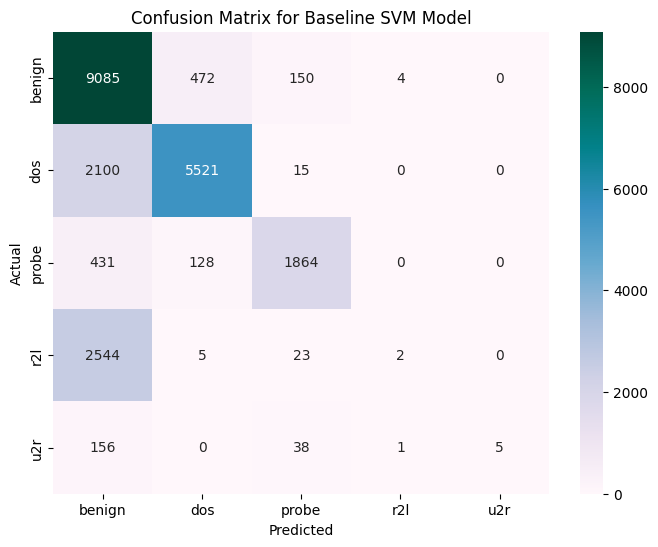

In [14]:
# Train the baseline SVM model using the original features
svm = SVC(kernel='linear')
svm.fit(train_X_scaled, train_Y)

# Predict the test set and evaluate accuracy
y_pred_original = svm.predict(test_X_scaled)
acc_original = accuracy_score(test_Y, y_pred_original)

# Generate confusion matrix for baseline
conf_matrix_baseline = confusion_matrix(test_Y, y_pred_original)

# Display the accuracy of the baseline model
print(f"\nAccuracy of the SVM model on the original data: {acc_original:.4f}")
plot_confusion_matrix(conf_matrix_baseline, "Confusion Matrix for Baseline SVM Model")

## 7. Visualizing the Explained Variance

The cumulative explained variance is plotted as a function of the number of principal components retained. This helps visualize how much of the variance is preserved as more components are retained in the PCA process.

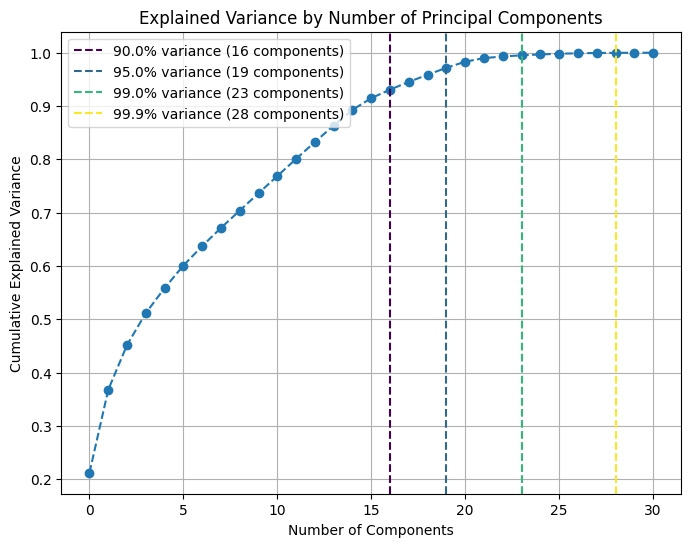

In [19]:
# Plot cumulative explained variance ratio
variance_levels = [0.90, 0.95, 0.99, 0.999]
pca = PCA().fit(train_X_scaled)
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
colors = plt.cm.viridis(np.linspace(0, 1, len(variance_levels)))
for i, variance in enumerate(variance_levels):
    n_components = np.where(np.cumsum(pca.explained_variance_ratio_) >= variance)[0][0] + 1
    plt.axvline(x=n_components, linestyle='--', label=f"{variance*100:.1f}% variance ({n_components} components)", color=colors[i])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.legend()
plt.grid(True)
plt.show()

## 8. Discussion

1. **How many new features are there after the PCA?**
- After applying PCA to the dataset with different variance thresholds, the number of new features (components) varies as follows:

    - $95.0\%$ variance: $19$ components
    - $99.0\%$ variance: $23$ components
    - $99.9\%$ variance: $28$ components
    - $90.0\%$ variance: $16$ components
    
    Thus, the number of new features after PCA depends on the variance threshold selected, with fewer features retained as the variance threshold increases.

2. **Discuss the "goodness" of the model, compared with the one without scaling (from Task 1), by comparing the accuracy**
- When comparing the SVM model's accuracy on the original data (Task 1) to the model with PCA, the following results were observed:

    - Accuracy of the SVM model on the original data (Task 1): $0.7308$
    - Accuracy with $95.0\%$ variance after PCA: $0.7279$
    - Accuracy with $99.0\%$ variance after PCA: $0.7302$
    - Accuracy with $99.9\%$ variance after PCA: $0.7298$
    - Accuracy with $90.0\%$ variance after PCA: $0.7263$

    The accuracy of the PCA models is generally similar to or slightly lower than the original model's accuracy. The best-performing model after PCA is the one with $99.0\%$ variance (accuracy of $0.7302$), which is a slight improvement over the original model's accuracy of $0.7308$. However, other variance thresholds yield comparable or slightly lower accuracies. Therefore, the model's "goodness" remains similar across both the original and PCA-transformed data, with minimal improvement observed in the PCA-based models.

3. **How about if we set the variance to $99\%$? And how about $99.9\%$?**
- Setting the variance threshold to $99.0\%$ results in the highest accuracy among the PCA models, with an accuracy of $0.7302$, which is very close to the original model's accuracy of $0.7308$. This shows a slight improvement.

    However, when setting the variance threshold to $99.9\%$, the accuracy is $0.7298$, which is slightly lower than the original model. Therefore, the accuracy with $99.0\%$ variance is slightly better than with $99.9\%$ variance, but the difference is minimal.

4. **Can you get better accuracy with fewer features using PCA compared to dropping the features from Task 1?**
- In Task 1, the model was trained with $31$ features after applying univariate feature selection. When PCA was applied with different variance thresholds, the number of components was as follows:

    - $95.0\%$ variance: $19$ components
    - $99.0\%$ variance: $23$ components
    - $99.9\%$ variance: $28$ components
    - $90.0\%$ variance: $16$ components

    The accuracy of the PCA models is comparable to or slightly worse than the accuracy achieved with the $31$ features in Task 1. For instance, the accuracy with $99.0\%$ variance after PCA is $0.7302$, which is very close to the original model's accuracy of $0.7308$, but with fewer components ($23$ components compared to $31$ features). While the reduction in features does not lead to a significant performance improvement, PCA provides a way to reduce dimensionality while maintaining similar accuracy.

---

# Task 3: Exploration

## Recursive Feature Elimination (RFE) for Feature Selection

Feature selection is an essential step in the machine learning pipeline that helps improve the efficiency and interpretability of a model. **Recursive Feature Elimination (RFE)** is one of the most widely used feature selection techniques. It iteratively removes the least important features and builds the model again, using the remaining features, until the most relevant features are retained.

**RFE** is commonly used with models that provide a ranking of feature importance, such as **Logistic Regression**, **SVMs**, or **Decision Trees**. In this notebook, **Logistic Regression** will be used as the estimator for feature importance ranking.

In this notebook, **RFE** will be applied to the **KDD** dataset to identify the most significant features for model training, demonstrating how this method can improve model performance and reduce complexity.

## 1. Import Dependencies

In [44]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 2. Load the Dataset

The dataset contains various features, with the goal of predicting the `attack_category` based on these features. Preprocessing is done to focus on numerical features.

In [45]:
# Load the dataset
train_df = pd.read_csv('KDDTrain_CE4317.csv', header=0)
test_df = pd.read_csv('KDDTest_CE4317.csv', header=0)

# Identify numerical columns
col_names = train_df.columns.values
nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 19, 20]
numeric_idx = list(set(range(40)).difference(nominal_idx).difference(binary_idx))
numeric_cols = col_names[numeric_idx].tolist()

# Extract numerical features for training and test sets
train_X = train_df[numeric_cols]
test_X = test_df[numeric_cols]
train_Y = train_df['attack_category']
test_Y = test_df['attack_category']

# Initial data inspection
print(f"Training data shape: {train_X.shape}")
print(f"Testing data shape: {test_X.shape}")
train_X.head()

Training data shape: (25192, 31)
Testing data shape: (22544, 31)


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,491,0,0,0,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,146,0,0,0,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,0,0,0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,232,8153,0,0,0,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,199,420,0,0,0,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## 3. Data Preprocessing

`StandardScaler` will be used to scale the features to have a mean of $0$ and a standard deviation of $1$. This step ensures that the model doesn't give more weight to features with larger values.

In [46]:
# Standardizing the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

## 4. Implementing RFE

### a. Model Selection

For feature ranking, a **Logistic Regression** model is used because it provides easily interpretable coefficients that represent feature importance in a classification task.

In [52]:
# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Initialize RFE with Logistic Regression as the estimator and select top 20 features
selector = RFE(estimator=model, n_features_to_select=25)
selector = selector.fit(train_X_scaled, train_Y)

# Get the ranking of features (1 means selected, higher values indicate less importance)
ranking = selector.ranking_

# Get the selected features
selected_features = [col_names[i] for i in range(len(ranking)) if ranking[i] == 1]
print(f"Selected Features: {selected_features}")

Selected Features: ['duration', 'protocol_type', 'service', 'flag', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_compromised', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate']


### b. Feature Ranking and Selection

The RFE process ranks the features based on their importance, with a ranking of $1$ indicating the most important features. In this case, the top $25$ most important features are selected for further modeling.

The bar plot visualizes the ranking of features, where a lower ranking indicates higher importance. Features with the lowest rankings are selected as the most important features.

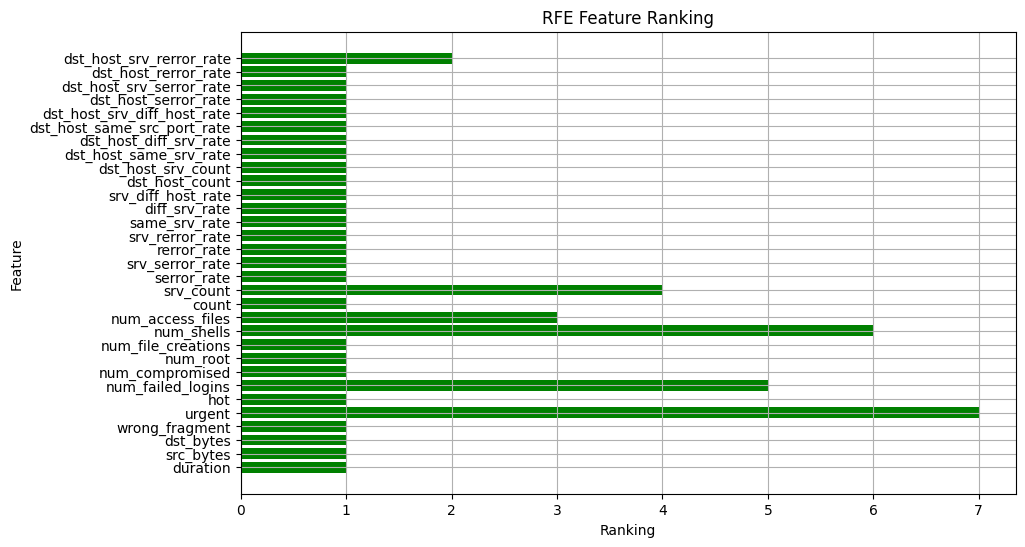

In [48]:
# Plotting the ranking of features
plt.figure(figsize=(10, 6))
plt.barh(numeric_cols, ranking, color='green')
plt.title('RFE Feature Ranking')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

## 5. Evaluating Feature Selection

To evaluate the effectiveness of the feature selection process, the performance of two models are compared: one trained with all features and another trained with the selected features. The evaluation metric used is the **accuracy score** on the test set.

The results show the accuracy of the models trained with all features versus the models trained with only the selected features. This comparison helps determine whether feature selection leads to improved performance or reduced complexity without sacrificing accuracy.

In [49]:
# Train Logistic Regression on all features
model_all = LogisticRegression(max_iter=1000)
model_all.fit(train_X_scaled, train_Y)

# Train Logistic Regression on selected features
train_X_selected = train_X_scaled[:, selector.support_]
model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(train_X_selected, train_Y)

# Evaluate both models
score_all = model_all.score(test_X_scaled, test_Y)
score_selected = model_selected.score(test_X_scaled[:, selector.support_], test_Y)

# Print out the accuracy results
print(f"Accuracy with all features: {score_all:.4f}")
print(f"Accuracy with selected features: {score_selected:.4f}")

Accuracy with all features: 0.7359
Accuracy with selected features: 0.7362


### Discussing the results

The model trained using all features from the dataset achieved an accuracy of approximately $73.59\%$. This serves as the baseline performance, where no feature selection was applied. All available features were used in the model, which may include irrelevant or redundant information that does not contribute to predictive power.

After performing *Recursive Feature Elimination* (**RFE**) and selecting the top $25$ features, the model’s accuracy increased slightly to approximately $73.62\%$. This indicates a marginal improvement in performance. The RFE process helps in eliminating less important features, which can reduce noise and overfitting, leading to a more efficient and interpretable model.

## 6. Importance of Feature Selection

Feature selection plays a crucial role in improving machine learning models. The key benefits of feature selection include:
- **Improved Accuracy**: By focusing on the most important features, the model avoids overfitting to irrelevant or redundant data, potentially improving accuracy.
- **Reduced Overfitting**: With fewer features, the model is less likely to memorize the training data, helping it generalize better to unseen data.
- **Increased Efficiency**: Reducing the number of features decreases computational costs, speeding up model training and inference.
- **Better Interpretability**: A model with fewer features is easier to understand and interpret, which is important in many real-world applications, such as cybersecurity.